In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns

Using TensorFlow backend.


In [2]:
np.random.seed(1995425)

In [3]:
def parser(x):
    return pd.datetime.strptime(x, '%m-%d-%Y')

data = pd.read_csv('./data/usdinr_dataset.csv',header=0,parse_dates=[0],date_parser=parser)

In [4]:
data.head()

,Date,USD/INR,BSE Sensex,Gold Price
0,2018-01-19,63.83,35511.58,1333.1
1,2018-01-18,63.87,35260.29,1327.2
2,2018-01-17,63.89,35081.82,1339.2
3,2018-01-16,64.02,34771.05,1337.1
4,2018-01-15,63.52,34843.51,1341.8


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


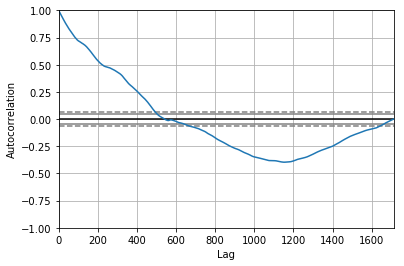

In [5]:
series = pd.Series.from_csv('./data/usdinr_dataset.csv',header=0)
autocorrelation_plot(series)
plt.show()

In [6]:
corre = data.corr()
corre

,USD/INR,BSE Sensex,Gold Price
USD/INR,1.000000,0.755530,-0.856715
BSE Sensex,0.755530,1.000000,-0.721223
Gold Price,-0.856715,-0.721223,1.000000


In [7]:
def diagonal_correlation_matrix(correlation):
    mask = np.zeros_like(correlation, dtype=np.bool)
    #np.triu_indices_from:
    #Returns the indices for the upper-triangle of arr
    
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(12,8))
    
    cmap = sns.diverging_palette(220,10,as_cmap=True)
    
    sns.heatmap(correlation, mask =mask,cmap=cmap,
               vmax=.3,center=0,square=True,linewidths=.5)

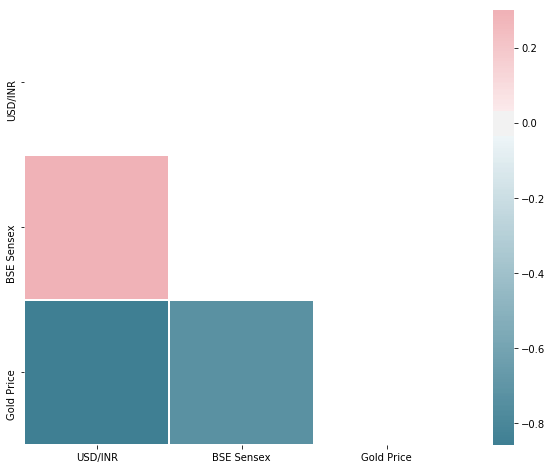

In [8]:
diagonal_correlation_matrix(corre)

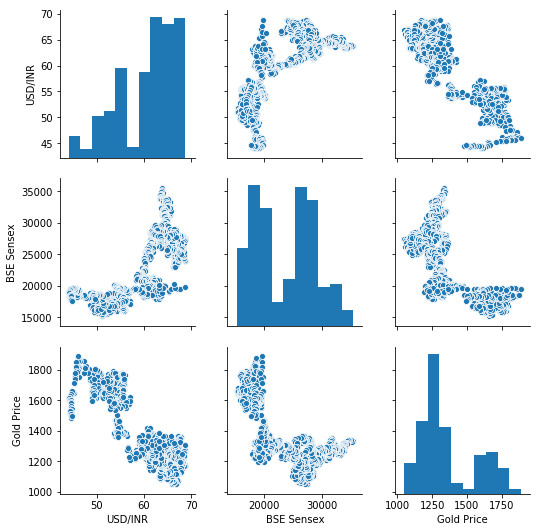

In [9]:
sns.pairplot(data)

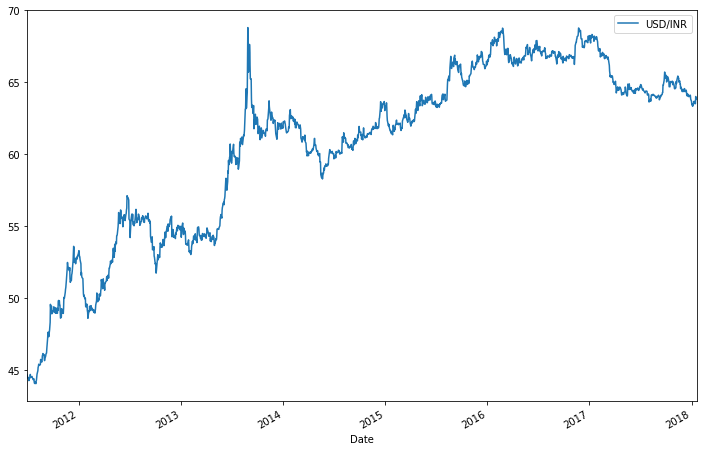

In [10]:
data.plot(y='USD/INR',x='Date',figsize=(12,8))
plt.show()

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
data = pd.read_csv('./data/usdinr_dataset.csv',header=0,index_col=0)
values = data.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled,1,1)
reframed.drop(reframed.columns[[4,5]],axis=1,inplace=True)

In [13]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.798707,1.000000,0.336914,0.800323
2,0.800323,0.987643,0.329872,0.801132
3,0.801132,0.978868,0.344194,0.806386
4,0.806386,0.963586,0.341687,0.786176
5,0.786176,0.967149,0.347297,0.789814


In [15]:
train = reframed.values[:int(len(reframed)*0.75),:]
test = reframed.values[int(len(reframed)*0.75):,:]
n_test = len(reframed)- int(len(reframed)*0.75)
X_train, y_train = train[:,:-1], train[:,-1]
X_test, y_test = test[:,:-1], test[:,-1]
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

In [16]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1283, 1, 3) (428, 1, 3) (1283,) (428,)


In [17]:
model = Sequential()
from keras import regularizers
model.add(LSTM(500,input_shape=(X_train.shape[1],X_train.shape[2]),kernel_regularizer=regularizers.l1(0.01)))

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 500)               1008000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 1,008,501
Trainable params: 1,008,501
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, epochs =100,batch_size=100,
                   validation_data=(X_test,y_test),verbose=1,shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 1283 samples, validate on 428 samples
Epoch 1/100
1283/1283 [==============================] - 2s 2ms/step - loss: 2.0478 - mean_squared_error: 0.4848 - val_loss: 1.2327 - val_mean_squared_error: 0.0381
Epoch 2/100
1283/1283 [==============================] - 1s 532us/step - loss: 1.2891 - mean_squared_error: 0.2209 - val_loss: 0.7165 - val_mean_squared_error: 0.0135
Epoch 3/100
1283/1283 [==============================] - 1s 548us/step - loss: 0.6731 - mean_squared_error: 0.0460 - val_loss: 0.6352 - val_mean_squared_error: 0.0814
Epoch 4/100
1283/1283 [==============================] - 1s 535us/step - loss: 0.3615 - mean_squared_error: 0.0089 - val_loss: 0.4737 - val_mean_squared_error: 0.0794
Epoch 5/100
1283/1283 [==============================] - 1s 525us/step - loss: 0.2562 - mean_squared_error: 0.0090 - val_loss: 0.4005 - val_mean_squared_error: 0.0725
Epoch 6/100
1283/1283 [==============================] - 1s 549us/step -

Epoch 48/100
1283/1283 [==============================] - 1s 599us/step - loss: 0.1336 - mean_squared_error: 0.0214 - val_loss: 0.4772 - val_mean_squared_error: 0.2353
Epoch 49/100
1283/1283 [==============================] - 1s 556us/step - loss: 0.1329 - mean_squared_error: 0.0213 - val_loss: 0.4774 - val_mean_squared_error: 0.2355
Epoch 50/100
1283/1283 [==============================] - 1s 582us/step - loss: 0.1334 - mean_squared_error: 0.0214 - val_loss: 0.4776 - val_mean_squared_error: 0.2360
Epoch 51/100
1283/1283 [==============================] - 1s 566us/step - loss: 0.1327 - mean_squared_error: 0.0213 - val_loss: 0.4776 - val_mean_squared_error: 0.2360
Epoch 52/100
1283/1283 [==============================] - 1s 589us/step - loss: 0.1332 - mean_squared_error: 0.0214 - val_loss: 0.4778 - val_mean_squared_error: 0.2365
Epoch 53/100
1283/1283 [==============================] - 1s 645us/step - loss: 0.1324 - mean_squared_error: 0.0214 - val_loss: 0.4779 - val_mean_squared_error:

Epoch 97/100
1283/1283 [==============================] - 1s 539us/step - loss: 0.1311 - mean_squared_error: 0.0212 - val_loss: 0.4796 - val_mean_squared_error: 0.2386
Epoch 98/100
1283/1283 [==============================] - 1s 571us/step - loss: 0.1316 - mean_squared_error: 0.0213 - val_loss: 0.4799 - val_mean_squared_error: 0.2388
Epoch 99/100
1283/1283 [==============================] - 1s 572us/step - loss: 0.1311 - mean_squared_error: 0.0212 - val_loss: 0.4798 - val_mean_squared_error: 0.2389
Epoch 100/100
1283/1283 [==============================] - 1s 578us/step - loss: 0.1316 - mean_squared_error: 0.0213 - val_loss: 0.4803 - val_mean_squared_error: 0.2393


## Get Prediction (y_hat) and Inverse

In [21]:
def get_y_hat(X_test, y_test):
    yhat = model.predict(X_test)
    '''
    真的蠢，这屌code写的。。。。
    X_train, X_test, y_train, y_test
    (1283, 1, 3) (428, 1, 3) (1283,) (428,)
    
    '''
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))
    #428,3
    inv_yhat = np.concatenate((yhat,X_test[:,1:]),axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    y_test = y_test.reshape((len(y_test),1))
    #428, 1
    inv_y = np.concatenate((y_test, X_test[:,1:]),axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    rmse = np.sqrt(mean_squared_error(inv_y,inv_yhat))
    print('TEST RMSE: %.3f'%rmse)
    print(inv_yhat.shape)
    inv_yhat = inv_yhat.reshape((n_test,1))
    inv_y = inv_y.reshape((n_test,1))
    
    inv_yhat = pd.DataFrame(inv_yhat)
    inv_y = pd.DataFrame(inv_y)
    
    return inv_yhat,inv_y

TEST RMSE: 12.103
(428,)


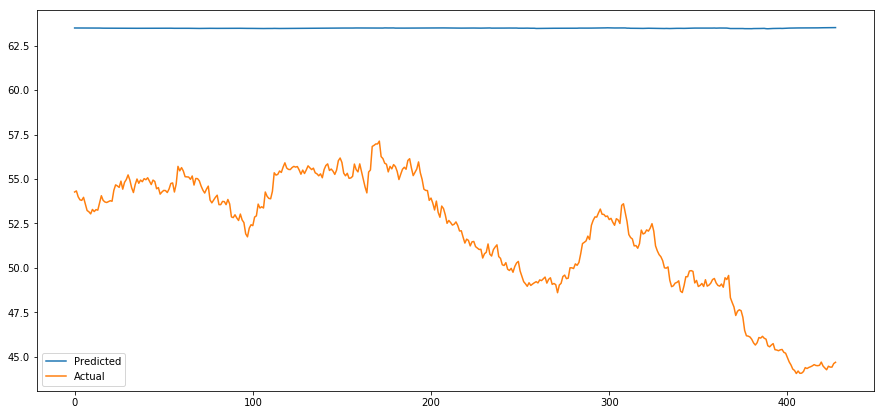

In [22]:
inv_yhat, inv_y = get_y_hat(X_test,y_test)
plt.figure(figsize=(15,7))
plt.plot(inv_yhat,label='Predicted')
plt.plot(inv_y,label='Actual')
plt.legend()

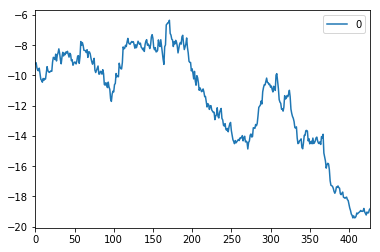

In [23]:
errr = inv_y - inv_yhat
errr.plot()
plt.show()